In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
df=pd.read_csv('rugvedlin.csv')

In [21]:
df.columns

Index(['carat', 'cut', 'color', 'clarity', 'depth', 'table', 'x', 'y', 'z',
       'price'],
      dtype='object')

In [22]:
df = df[(df[['x','y','z']] != 0).all(axis=1)]

In [23]:
df.describe()


,carat,depth,table,x,y,z,price
count,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000
mean,0.795368,61.720080,57.490596,5.731005,5.716316,3.528779,7.846779
std,0.485184,5.160848,5.473837,1.492658,1.503996,1.216390,8.000676
min,0.020265,39.768041,36.987798,0.031002,0.307422,0.006598,0.652000
25%,0.405042,58.227008,53.812489,4.659935,4.631587,2.684302,1.886000
50%,0.684387,61.720635,57.388137,5.681654,5.678285,3.508792,4.734000
75%,1.074885,65.219405,61.172691,6.747104,6.738530,4.361609,10.730000
max,4.445496,81.160537,84.895276,11.133427,11.205688,7.983576,37.608000


In [24]:
df.corr()

ValueError: could not convert string to float: 'Ideal'

In [25]:
df=df.replace({'color' : { 'D' : 6, 'E' : 5, 'F' : 4, 'G' : 3, 'H': 2, 'I':1, 'J':0}})
df=df.replace({'cut': {'Ideal':4, 'Premium': 3, 'Good':1,'Very Good':2,'Fair':0}})
df=df.replace({'clarity': {"IF": 8, 'VVS1' :7, 'VVS2': 6, 'VS1': 5, 'VS2': 4, 'SI1':3, 'SI2': 2, 'I1':1, 'I2':0, 'I3':0}})

In [26]:
df['volume']= df['x']*df['y']*df["z"] 
df=df.drop(['x','y','z'], axis=1)

In [27]:
df.describe()

,carat,cut,color,clarity,depth,table,price,volume
count,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000
mean,0.795368,2.911250,3.399500,4.067833,61.720080,57.490596,7.846779,129.050237
std,0.485184,1.117204,1.707477,1.652713,5.160848,5.473837,8.000676,90.367833
min,0.020265,0.000000,0.000000,1.000000,39.768041,36.987798,0.652000,0.004649
25%,0.405042,2.000000,2.000000,3.000000,58.227008,53.812489,1.886000,60.592183
50%,0.684387,3.000000,3.000000,4.000000,61.720635,57.388137,4.734000,106.522132
75%,1.074885,4.000000,5.000000,5.000000,65.219405,61.172691,10.730000,176.043783
max,4.445496,4.000000,6.000000,8.000000,81.160537,84.895276,37.608000,707.693141


<Axes: >

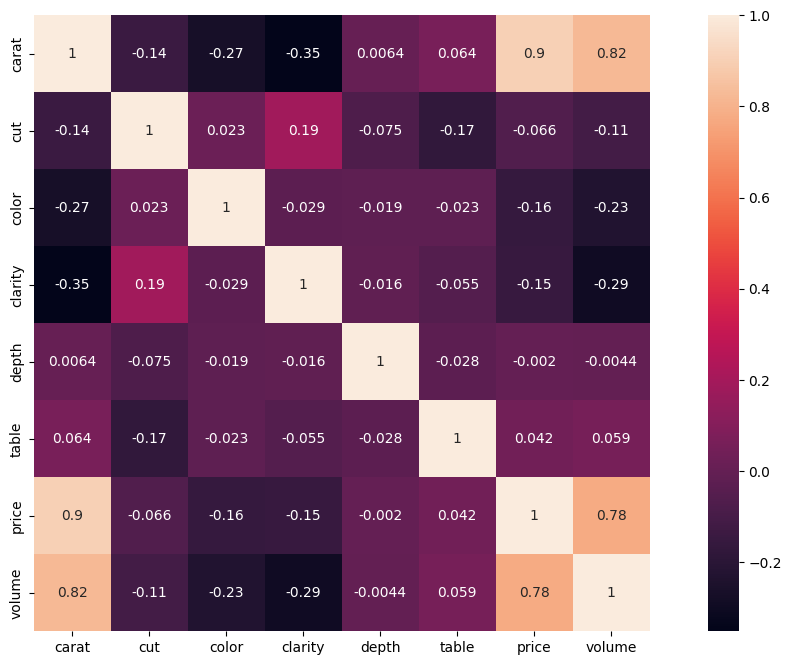

In [28]:
corr = df.corr()
plt.figure(figsize = (15,8))
sns.heatmap(data=corr, square=True , annot=True, cbar=True)

In [29]:
df=df.drop(['volume'], axis=1)

In [30]:
def interQuartile(x):    
    percentile25= x.quantile(0.25)    
    percentile75=x.quantile(0.75)    
    iqr=percentile75-percentile25    
    upperLimit= percentile75+1.5*iqr    
    lowerLimit= percentile25-1.5*iqr    
    return upperLimit, lowerLimit

In [31]:
upper,lower= interQuartile(df['depth'])
df= df[df['depth'] < upper]
df= df[df['depth']>lower]

In [32]:
df.shape

(11920, 7)

In [33]:
cols = ['carat', 'depth', 'table']
for col in cols:
    mean_val = df[col].mean()
    std_val = df[col].std()
    df[col] = (df[col] - mean_val) / std_val
df[cols] = df[cols].fillna(df[cols].mean())
print(df.head())

      carat  cut  color  clarity     depth     table   price
0 -0.516239    4      5        3  0.434240 -0.897200   3.558
1  2.632827    3      0        3  1.179361  0.030805  24.738
2 -0.390114    3      3        5 -1.221700  0.528804   3.630
3 -0.206370    3      3        2 -0.229279  2.524989   4.218
4 -1.056605    4      5        6  1.444339 -0.569344   1.578


In [34]:
y= df['price'] 
x= df.drop(['price'], axis=1)

In [35]:
def train_test_split(x, y, test_size=0.2, random_seed=42):
    if random_seed is not None:
        np.random.seed(random_seed)

    indices = np.arange(len(x))
    np.random.shuffle(indices)

    test_samples = int(len(x) * test_size)

    test_indices = indices[:test_samples]
    train_indices = indices[test_samples:]

    x_train, x_test = x.iloc[train_indices], x.iloc[test_indices]
    y_train, y_test = y.iloc[train_indices], y.iloc[test_indices]

    return x_train.values, x_test.values, y_train.values, y_test.values


In [36]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

In [37]:
def linear_regression(x, y, learning_rate=0.01, epochs=1000):
    x = np.array(x)
    y = np.array(y).reshape(-1, 1)
    cost_list=[]
    w = np.zeros((x.shape[1], 1))
    b = 0

    n = float(len(x))

    # Gradient Descent
    for epoch in range(epochs):
        y_pred = np.dot(x, w) + b
        error = y_pred - y
        mse = np.mean(error**2)
        w -= (2/n) * learning_rate * np.dot(x.T, error)
        b -= (2/n) * learning_rate * np.sum(error)
        cost_list.append(mse)

        if epoch % 100 == 0:
            print(f"Epoch {epoch}: Mean Squared Error (MSE) = {mse}")
            
    return w, b,cost_list

weights, bias, a = linear_regression(x_train, y_train, learning_rate=0.01, epochs=1000)

y_pred = np.dot(x_test, weights) + bias


Epoch 0: Mean Squared Error (MSE) = 125.69708611577182
Epoch 100: Mean Squared Error (MSE) = 10.47440116898441
Epoch 200: Mean Squared Error (MSE) = 9.093869679227836
Epoch 300: Mean Squared Error (MSE) = 9.050915344903952
Epoch 400: Mean Squared Error (MSE) = 9.049325614471927
Epoch 500: Mean Squared Error (MSE) = 9.049205941543505
Epoch 600: Mean Squared Error (MSE) = 9.049151671005614
Epoch 700: Mean Squared Error (MSE) = 9.049108871883224
Epoch 800: Mean Squared Error (MSE) = 9.049073880451866
Epoch 900: Mean Squared Error (MSE) = 9.049045223462652


ValueError: shapes (100,2) and (6,1) not aligned: 2 (dim 1) != 6 (dim 0)

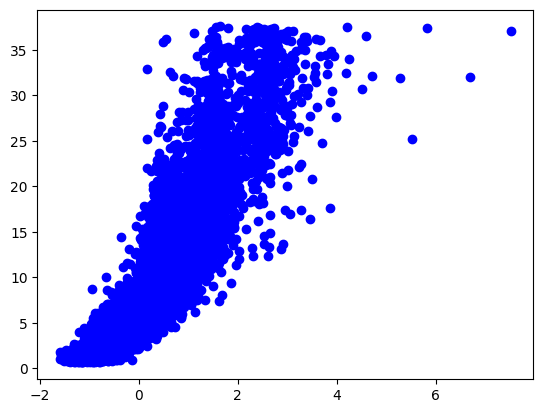

In [38]:
plt.scatter(x_train[:, 0], y_train, color='blue', label='Actual Data')
weights = np.array([[ 8.09047547,  0.29064669,  0.5682344 ,  0.9748099 ,  0.01226385,-0.00879841]])
# Plotting the linear regression line
x_range = np.linspace(min(x_train[:, 0]), max(x_train[:, 0]), 100).reshape(-1, 1)
y_pred_range = np.dot(np.c_[x_range, np.ones_like(x_range)], weights.T)
plt.plot(x_range, y_pred_range, color='red', label='Linear Regression')
plt.xlabel('factors')  
plt.ylabel('Price')  
plt.title('Linear Regression')
plt.legend()
plt.show()

In [39]:
n = x_test.shape[0]
y_pred = np.dot(x_test, weights)
error = (1/n) * np.sum(np.abs(y_pred - Y_test.reshape(-1, 1)))

error

ValueError: shapes (2384,6) and (1,6) not aligned: 6 (dim 1) != 1 (dim 0)

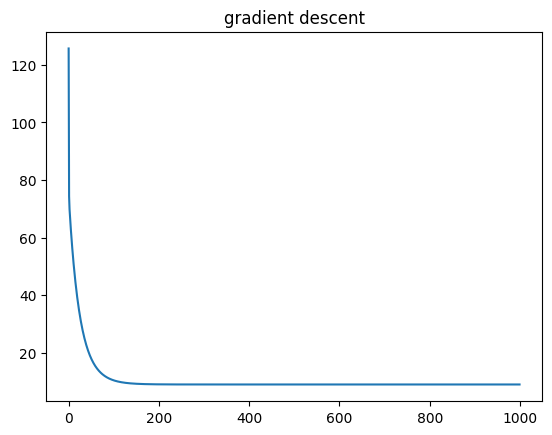

In [40]:
rg= np.arange(0,1000)
plt.title('gradient descent')
plt.plot(rg, a[:1000])
plt.show()

In [19]:
r2 = r2_score(y_test, y_pred)
r2

NameError: name 'y_pred' is not defined